In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'config_score.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'wiki', 'storage_dir': '../data/', 'embedding_config': './embedding_config.json', 'criteria': 'score', 'train_ratio': 0.3, 'hidden_dim': 256, 'max_hops': 6, 'num_neg': 3, 'num_threads': 2, 'decay_factor': 0.2, 'max_fanout': 100, 'beam_width': 20, 'max_epochs': 2, 'batch_size': 8, 'dim_feedforward': 256, 'nhead': 4, 'num_layers': 6, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'positive_deviation': True, 'embedding': 'all', 'test_time': 1, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False, 'lr': 0.0001, 'wandb_project': 'thesis-graph'}


In [2]:
import os, requests, json, pprint

cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
assert cid and key, "Not running on a Vast.ai container!"

resp = requests.get(
    f"https://console.vast.ai/api/v0/instances/{cid}/",
    headers={"Authorization": f"Bearer {key}",
             "accept": "application/json"},
    timeout=10,
)

info = resp.json()
print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
# print(info['instances'].keys())

Effective vCPUs: 24.0


In [3]:

# Initialize the DataModule and load the data
print("Setting up DataModule...")
dm = PathDataModule(config_path=config_path, batch_size=32)
dm.setup('fit')
print("Data loaded.")


Setting up DataModule...
Setting up data for stage: fit
Setting up data for split: train
Negative paths file not found for train split: ../data/transe_wiki_train_neg.json. Skipping negative paths setup.
Pre-scan enabled for train split. Running full data validation...

--- Pre-scanning and filtering train data points ---
Scanning 1887995 edges in train split...


Scanning edges: 100%|██████████| 1887995/1887995 [00:02<00:00, 905362.85it/s]



Pre-scan Results for train:
  Total edges scanned: 1887995
  Valid edges (has pos & neg paths): 768820 (40.7%)
  Missing positive paths: 1119175 (59.3%)
  Missing negative paths: 1887995 (100.0%)
  Empty negative paths: 0 (0.0%)

⚠️  WARNING: Some edges are missing required path data!
  Filtering train split to keep only 768820 valid edges.
  New edge count for train: 768820
--- Pre-scan complete ---

Use shallow embeddings: True at config ./embedding_config.json
Loaded 768820 edges for train split.
Setting up data for split: valid
Negative paths file not found for valid split: ../data/transe_wiki_valid_neg.json. Skipping negative paths setup.
Pre-scan not configured for valid split. Skipping data validation.
Use shallow embeddings: True at config ./embedding_config.json
Loaded 337690 edges for valid split.
Setting up data for split: test
Negative paths file not found for test split: ../data/transe_wiki_test_neg.json. Skipping negative paths setup.
Pre-scan not configured for test spl

In [4]:

# --- 2. Data Extraction and Preparation ---
plot_data = []
split = 'test'  # You can change this to 'valid' or 'test'

print(f"Processing data for '{split}' split...")
edges_df = dm.data[split]
pos_paths = dm.pos_paths[split]
neg_paths = dm.neg_paths[split]


Processing data for 'test' split...


In [5]:
print(len(pos_paths), len(neg_paths))

146039 0


In [6]:
edges_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315550 entries, 2549059 to 2864608
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  315550 non-null  int64
 1   feat_pos_v  315550 non-null  int64
 2   u           315550 non-null  int64
 3   v           315550 non-null  int64
 4   u_type      315550 non-null  int64
 5   v_type      315550 non-null  int64
 6   ts          315550 non-null  int64
 7   split       315550 non-null  int64
 8   label       315550 non-null  int64
 9   edge_type   315550 non-null  int64
 10  v_pos       315550 non-null  int64
dtypes: int64(11)
memory usage: 28.9 MB


In [7]:
edges_df[edges_df['v_pos'] == edges_df['v']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 126220 entries, 2549059 to 2849800
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  126220 non-null  int64
 1   feat_pos_v  126220 non-null  int64
 2   u           126220 non-null  int64
 3   v           126220 non-null  int64
 4   u_type      126220 non-null  int64
 5   v_type      126220 non-null  int64
 6   ts          126220 non-null  int64
 7   split       126220 non-null  int64
 8   label       126220 non-null  int64
 9   edge_type   126220 non-null  int64
 10  v_pos       126220 non-null  int64
dtypes: int64(11)
memory usage: 11.6 MB


In [8]:
edges_df[edges_df['v_pos'] == edges_df['v']].describe()

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
count,126220.000000,126220.000000,126220.000000,126220.000000,126220.0,126220.0,126220.000000,126220.0,126220.0,126220.000000,126220.000000
mean,4960.723475,4960.723475,5458.843424,5458.843424,0.0,0.0,226.175170,3.0,1.0,22.366344,5458.843424
std,4063.349577,4063.349577,4016.725397,4016.725397,0.0,0.0,2.809937,0.0,0.0,13.442329,4016.725397
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,222.000000,3.0,1.0,0.000000,0.000000
25%,1672.000000,1672.000000,1604.000000,1604.000000,0.0,0.0,224.000000,3.0,1.0,9.000000,1604.000000
50%,3317.000000,3317.000000,4774.000000,4774.000000,0.0,0.0,226.000000,3.0,1.0,23.500000,4774.000000
75%,9756.000000,9756.000000,9340.250000,9340.250000,0.0,0.0,229.000000,3.0,1.0,33.000000,9340.250000
max,12552.000000,12552.000000,12434.000000,12434.000000,0.0,0.0,231.000000,3.0,1.0,47.000000,12434.000000


In [9]:
edges_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u     v_pos edge_type ts                                                      
0     1     0         222           4           4  4       4       4      4   
                      223           4           4  4       4       4      4   
                      224           4           4  4       4       4      4   
                      225           4           4  4       4       4      4   
                      226           4           4  4       4       4      4   
...                               ...         ... ..     ...     ...    ...   
12433 2449  9         231           4           4  4       4       4      4   
      3970  17        231           4           4  4       4       4      4   
12434 842   29        231           1           1  1       1       1      1   
      976   29        231           1           1  1       1       1      1   
      1153  29        231           1           1  1       1       1      1   

                           label  
u     v_pos edge_type ts          
0     1     0         222      4  
                      223      4  
                      224      4  
                      225      4  
                      226      4  
...                          ...  
12433 2449  9         231      4  
      3970  17        231      4  
12434 842   29        231      1  
      976   29        231      1  
      1153  29        231      1  

[123768 rows x 7 columns]

In [10]:

for eid, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Extracting paths"):
    eid_str = str(eid)
    label = row['label']
    u = row['u']
    v = row['v']
    ts = row['ts']
    v_pos = row['v_pos']
    edge_type = row['edge_type']
    edge_meta = {}

    # Process positive path
    if eid_str in pos_paths and pos_paths[eid_str].get('nodes'):
        pos_path_len = len(pos_paths[eid_str]['nodes'])
        edge_meta = {
            'path_length': pos_path_len,
            # 'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link',
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
            
        }
    else:
        edge_meta = {
            'path_length': 0,
            # 'path_type': 'positive',
            'label': 'true_link' if label == 1 else 'false_link',
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
        }

    # # Process negative paths
    # if eid_str in neg_paths:
    #     # for neg_path_interleaved in neg_paths[eid_str]:
    #     #     # As per loader.py, nodes are at even indices
    #     #     neg_path_len = len(neg_path_interleaved[::2])
    #     #     plot_data.append({
    #     #         'path_length': neg_path_len,
    #     #         'path_type': 'negative',
    #     #         'label': 'true_link' if label == 1 else 'false_link'
    #     #     })
    #     edge_meta["num_neg"] = len(neg_paths[eid_str])

    plot_data.append(edge_meta)

Extracting paths: 100%|██████████| 315550/315550 [00:10<00:00, 29268.72it/s]


In [11]:

plot_df = pd.DataFrame(plot_data)
print("Data prepared for plotting.")


Data prepared for plotting.


In [12]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315550 entries, 0 to 315549
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   path_length  315550 non-null  int64 
 1   label        315550 non-null  object
 2   u            315550 non-null  int64 
 3   v            315550 non-null  int64 
 4   ts           315550 non-null  int64 
 5   edge_type    315550 non-null  int64 
 6   v_pos        315550 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 16.9+ MB


In [13]:
edges_fp = os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_edges.csv")
df = pd.read_csv(edges_fp, index_col='edge_id')            
split_map = {str(idx): row['split'] for idx, row in df.iterrows()}

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2864609 entries, 0 to 2864608
Data columns (total 11 columns):
 #   Column      Dtype
---  ------      -----
 0   feat_pos_u  int64
 1   feat_pos_v  int64
 2   u           int64
 3   v           int64
 4   u_type      int64
 5   v_type      int64
 6   ts          int64
 7   split       int64
 8   label       int64
 9   edge_type   int64
 10  v_pos       int64
dtypes: int64(11)
memory usage: 262.3 MB


In [15]:
df[(df['v_pos'] == df['v']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 126220 entries, 2549059 to 2849800
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  126220 non-null  int64
 1   feat_pos_v  126220 non-null  int64
 2   u           126220 non-null  int64
 3   v           126220 non-null  int64
 4   u_type      126220 non-null  int64
 5   v_type      126220 non-null  int64
 6   ts          126220 non-null  int64
 7   split       126220 non-null  int64
 8   label       126220 non-null  int64
 9   edge_type   126220 non-null  int64
 10  v_pos       126220 non-null  int64
dtypes: int64(11)
memory usage: 11.6 MB


In [16]:
df[(df['label'] == 1) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 126220 entries, 2549059 to 2849800
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  126220 non-null  int64
 1   feat_pos_v  126220 non-null  int64
 2   u           126220 non-null  int64
 3   v           126220 non-null  int64
 4   u_type      126220 non-null  int64
 5   v_type      126220 non-null  int64
 6   ts          126220 non-null  int64
 7   split       126220 non-null  int64
 8   label       126220 non-null  int64
 9   edge_type   126220 non-null  int64
 10  v_pos       126220 non-null  int64
dtypes: int64(11)
memory usage: 11.6 MB


In [17]:
df[(df['v_pos'] == df['u']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 2554894 to 2862583
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  50 non-null     int64
 1   feat_pos_v  50 non-null     int64
 2   u           50 non-null     int64
 3   v           50 non-null     int64
 4   u_type      50 non-null     int64
 5   v_type      50 non-null     int64
 6   ts          50 non-null     int64
 7   split       50 non-null     int64
 8   label       50 non-null     int64
 9   edge_type   50 non-null     int64
 10  v_pos       50 non-null     int64
dtypes: int64(11)
memory usage: 4.7 KB


In [18]:
df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u     v_pos edge_type ts                                                      
0     1     0         0             1           1  1       1       1      1   
                      1             1           1  1       1       1      1   
                      2             1           1  1       1       1      1   
                      3             1           1  1       1       1      1   
                      4             1           1  1       1       1      1   
...                               ...         ... ..     ...     ...    ...   
12433 2449  9         231           4           4  4       4       4      4   
      3970  17        231           4           4  4       4       4      4   
12434 842   29        231           1           1  1       1       1      1   
      976   29        231           1           1  1       1       1      1   
      1153  29        231           1           1  1       1       1      1   

                           label  
u     v_pos edge_type ts          
0     1     0         0        1  
                      1        1  
                      2        1  
                      3        1  
                      4        1  
...                          ...  
12433 2449  9         231      4  
      3970  17        231      4  
12434 842   29        231      1  
      976   29        231      1  
      1153  29        231      1  

[1324564 rows x 7 columns]

In [19]:
df[df["split"] == 2].groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u     v_pos edge_type ts                                                      
0     1     0         211           4           4  4       4       4      4   
                      212           4           4  4       4       4      4   
                      213           4           4  4       4       4      4   
                      214           4           4  4       4       4      4   
                      215           4           4  4       4       4      4   
...                               ...         ... ..     ...     ...    ...   
11684 9333  15        221           4           4  4       4       4      4   
11685 6771  15        221           4           4  4       4       4      4   
11686 8421  15        221           4           4  4       4       4      4   
11687 4429  15        221           4           4  4       4       4      4   
11688 9089  15        221           4           4  4       4       4      4   

                           label  
u     v_pos edge_type ts          
0     1     0         211      4  
                      212      4  
                      213      4  
                      214      4  
                      215      4  
...                          ...  
11684 9333  15        221      4  
11685 6771  15        221      4  
11686 8421  15        221      4  
11687 4429  15        221      4  
11688 9089  15        221      4  

[132986 rows x 7 columns]

In [20]:
# len(split_map.keys())

In [21]:
# list(split_map.values())[-1]

In [22]:
# split_code = {'pre': 0, 'train': 1, 'valid': 2, 'test': 3}

# print(f"Setting up data for split: {split}")

# pos_paths = {}
# with open(os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_paths.txt")) as f:
#     n_str = f.readline()
#     n = int(n_str) if n_str and n_str.strip() else 0
#     for _ in tqdm(range(n)):
#         eid = f.readline().strip()
#         if not eid:
#             break
#         hops = int(f.readline())
#         nodes = [int(u) for u in f.readline().split()]
#         node_types = [int(t) for t in f.readline().split()]
#         edge_types_str = f.readline().strip().split()
#         edge_types = [int(et) for et in edge_types_str if et]
        
#         edge_timestamps_str = f.readline().strip().split()
#         edge_timestamps = [int(ts) for ts in edge_timestamps_str if ts]

#         if split_map.get(eid) == split_code[split]:
#             pos_paths[eid] = {
#                 "hops": hops,
#                 "nodes": nodes,
#                 "node_types": node_types,
#                 "edge_types": edge_types,
#                 "edge_timestamps": edge_timestamps
#             }


In [23]:
# len(pos_paths.keys())

In [24]:
plot_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,true_link,1968,5262,222,5,5262
1,2,true_link,7794,7795,222,14,7795
2,2,true_link,2171,2172,222,17,2172
3,2,true_link,0,1,222,0,1
4,2,true_link,3668,7796,222,5,7796
...,...,...,...,...,...,...,...
315545,0,false_link,5489,10455,231,13,615
315546,0,false_link,5489,10545,231,13,615
315547,0,false_link,11755,4834,231,15,7846
315548,0,false_link,11755,4957,231,15,7846


In [25]:
pos_df = plot_df[plot_df["path_length"] > 0].copy()
pos_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,true_link,1968,5262,222,5,5262
1,2,true_link,7794,7795,222,14,7795
2,2,true_link,2171,2172,222,17,2172
3,2,true_link,0,1,222,0,1
4,2,true_link,3668,7796,222,5,7796
...,...,...,...,...,...,...,...
315533,5,false_link,195,2548,231,0,856
315537,7,false_link,4264,1325,231,17,9792
315542,4,false_link,8090,1204,231,14,1374
315544,7,false_link,5489,6667,231,13,615


In [26]:
temp = pos_df[pos_df["label"] == "true_link"].groupby("path_length").count()
temp

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,109952,109952,109952,109952,109952,109952
3,36,36,36,36,36,36
4,8490,8490,8490,8490,8490,8490
5,32,32,32,32,32,32
6,3371,3371,3371,3371,3371,3371
7,17,17,17,17,17,17


In [27]:
temp / temp.sum() * 100

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,90.200003,90.200003,90.200003,90.200003,90.200003,90.200003
3,0.029533,0.029533,0.029533,0.029533,0.029533,0.029533
4,6.964839,6.964839,6.964839,6.964839,6.964839,6.964839
5,0.026251,0.026251,0.026251,0.026251,0.026251,0.026251
6,2.765427,2.765427,2.765427,2.765427,2.765427,2.765427
7,0.013946,0.013946,0.013946,0.013946,0.013946,0.013946


In [28]:
pos_df[pos_df["label"] == "false_link"].groupby("path_length").count()

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
3,1193,1193,1193,1193,1193,1193
4,1630,1630,1630,1630,1630,1630
5,6325,6325,6325,6325,6325,6325
6,6474,6474,6474,6474,6474,6474
7,8519,8519,8519,8519,8519,8519


In [29]:
plot_df[plot_df["path_length"] < 2]

,path_length,label,u,v,ts,edge_type,v_pos
18,0,true_link,9782,11689,222,17,11689
20,0,true_link,11690,7028,222,17,7028
84,0,true_link,6430,11691,222,22,11691
90,0,true_link,11692,5160,222,17,5160
92,0,true_link,11693,11694,222,8,11694
...,...,...,...,...,...,...,...
315543,0,false_link,8090,946,231,14,1374
315545,0,false_link,5489,10455,231,13,615
315546,0,false_link,5489,10545,231,13,615
315547,0,false_link,11755,4834,231,15,7846


In [30]:
def calculate_metrics(group):
    """
    Calculates MRR and Hits@K for a group of predictions for a single query.
    The group contains one 'true_link' and multiple 'false_link' rows.
    A lower 'path_length' is considered a better score.
    """
    true_link = group[group['label'] == 'true_link']
    if true_link.empty or (true_link['path_length'].min() == 0):
        min_neg = 0 if group.loc[group['label'] == 'true_link', 'path_length'].min() > 0 else 1
        return pd.Series({
            'rank': min_neg-1, 'mrr': min_neg, 'hits@1': min_neg, 'hits@3': min_neg, 'hits@10': min_neg
        })

    # Lower path_length is better.
    true_path_length = true_link['path_length'].min()
    
    # Rank is 1 + number of negative samples with a better (smaller) or equal path length.
    # We use '<=' because if scores are tied, the true link does not get the best rank.
    rank = 1 + group[(group['label'] == 'false_link') & (group['path_length'] < true_path_length)].shape[0]
    
    mrr = 1.0 / rank
    hits_at_1 = 1.0 if rank <= 1 else 0.0
    hits_at_3 = 1.0 if rank <= 3 else 0.0
    hits_at_10 = 1.0 if rank <= 10 else 0.0
    
    return pd.Series({
        'rank': rank,
        'mrr': mrr,
        'hits@1': hits_at_1,
        'hits@3': hits_at_3,
        'hits@10': hits_at_10
    })


In [31]:

# Group by the query identifiers.
# This assumes that for each (u, v, ts, edge_type) combination that forms a true link,
# there are corresponding negative samples that share these identifiers in some way
# that allows grouping. If negative samples have different u or v, the grouping key needs adjustment.
# Based on the request, we group by ('u', 'v', 'ts', 'edge_type').
grouped = plot_df.groupby(['u', "v_pos", "edge_type", "ts"])


In [32]:

# Apply the function to each group and get the results.
metrics_df = grouped.apply(calculate_metrics, include_groups=False).reset_index()


In [33]:

print("Metrics per query:")
metrics_df


Metrics per query:


,u,v_pos,edge_type,ts,rank,mrr,hits@1,hits@3,hits@10
0,0,1,0,222,4.0,0.25,0.0,0.0,1.0
1,0,1,0,223,4.0,0.25,0.0,0.0,1.0
2,0,1,0,224,4.0,0.25,0.0,0.0,1.0
3,0,1,0,225,4.0,0.25,0.0,0.0,1.0
4,0,1,0,226,4.0,0.25,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
123763,12433,2449,9,231,0.0,1.00,1.0,1.0,1.0
123764,12433,3970,17,231,0.0,1.00,1.0,1.0,1.0
123765,12434,842,29,231,0.0,1.00,1.0,1.0,1.0
123766,12434,976,29,231,0.0,1.00,1.0,1.0,1.0


In [34]:

print("\nAverage metrics across all queries:")
metrics_df[['mrr', 'hits@1', 'hits@3', 'hits@10']].mean() * 100



Average metrics across all queries:


mrr         65.641336
hits@1      52.064346
hits@3      66.276420
hits@10    100.000000
dtype: float64

<Axes: ylabel='Frequency'>

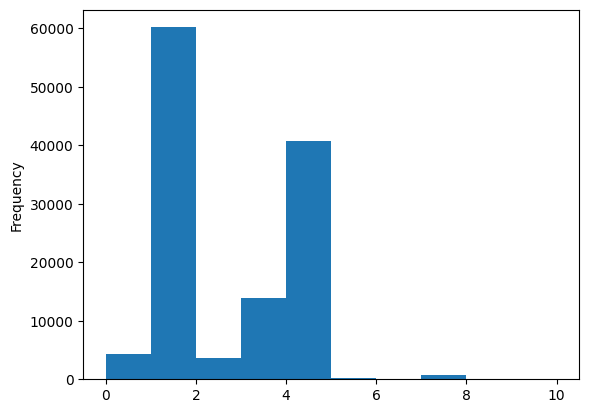

In [35]:
metrics_df['rank'].plot.hist(bins=10)

In [36]:
metrics_df.groupby('rank').count()

,u,v_pos,edge_type,ts,mrr,hits@1,hits@3,hits@10
rank,,,,,,,,
0.0,4286,4286,4286,4286,4286,4286,4286,4286
1.0,60153,60153,60153,60153,60153,60153,60153,60153
2.0,3621,3621,3621,3621,3621,3621,3621,3621
3.0,13969,13969,13969,13969,13969,13969,13969,13969
4.0,40713,40713,40713,40713,40713,40713,40713,40713
5.0,271,271,271,271,271,271,271,271
7.0,681,681,681,681,681,681,681,681
10.0,74,74,74,74,74,74,74,74


In [37]:
results = None
with open("../data/transe/icews14/thesis-graph/6anz0hpb/train_val_0_raw.json") as f:
    results = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../data/transe/icews14/thesis-graph/6anz0hpb/train_val_0_raw.json'

In [ ]:
len(results)

In [ ]:
len([result for result in results if result['label'] == 0])

In [ ]:
len([result for result in results if result['label'] == 1])

In [ ]:
results[0]

In [ ]:
result_df = pd.DataFrame(results)
result_df

In [ ]:
result_df.describe()

In [ ]:
result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

In [ ]:
test_df = pd.merge(df[df["split"] == 2], result_df, on=["u", "v_pos", "edge_type", "ts", "v", "label"])
test_df

In [ ]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

In [ ]:
test = result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()
test[test["v"] > 1]

In [ ]:
from evaluation import evaluate
from collections import defaultdict

In [ ]:
# edge_groups = defaultdict(lambda: {'pos_score': None, 'neg_scores': []})
# for item in results:
#     # Use v_pos as the target node for grouping, which is the true target for all edges
#     v_for_grouping = item.get('v_pos', item['v'])
#     key = (item['u'], item.get('edge_type'), v_for_grouping, item['ts'])
#     score = item['score']  # Now using the adjusted score
#     length = item['length']
    
#     if item['label'] == 1:
#         edge_groups[key]['pos_score'] = (score, length)
#     else:
#         edge_groups[key]['neg_scores'].append((score, length))

In [ ]:
# final = evaluate(edge_groups, verbose=False)
final = evaluate(results, verbose=False)
final

In [ ]:
test_df

In [ ]:
def process(group):
    return group.loc[group["label"] == 0, "length"].min()

In [ ]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).apply(process)

In [ ]:
check = pd.merge(result_df, plot_df, on=["u", "v", "v_pos", "ts", "edge_type"])
check

In [ ]:
(check['length'] - check['path_length'] + 1).max()